In [1]:
%matplotlib inline

from io import BytesIO
from base64 import b64encode

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

import numpy as np

import scipy.signal as sps

from IPython.display import HTML
import IPython.display 
from PIL import Image

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 32, 24

In [2]:
infd = open('he010-cbar.tbc', 'rb')

indata = infd.read()

data = np.fromstring(indata, 'uint16', len(indata)//2)

In [3]:
data

array([  141, 49152,   141, ..., 19353, 19055, 19571], dtype=uint16)

In [4]:
len(data)/505/844

58.0

(426220,)
uint8 (505, 844) (505, 844)


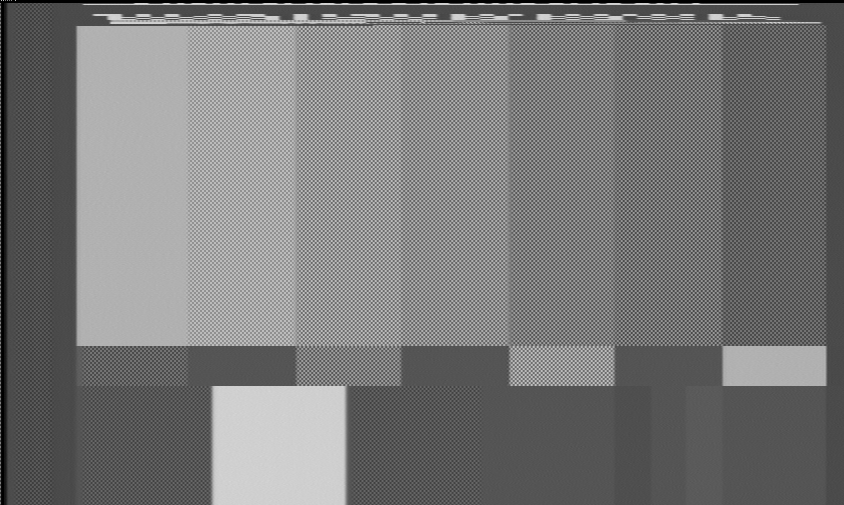

In [5]:
# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 844, y = 505, hscale = 1, vscale = 1, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
#    imshow(np.asarray(im))
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())
                         
drawdata(data)                         

In [6]:
import tensorflow as tf


In [7]:
data1 = data[:505*844]

(426220,)
uint8 (505, 844) (505, 844)


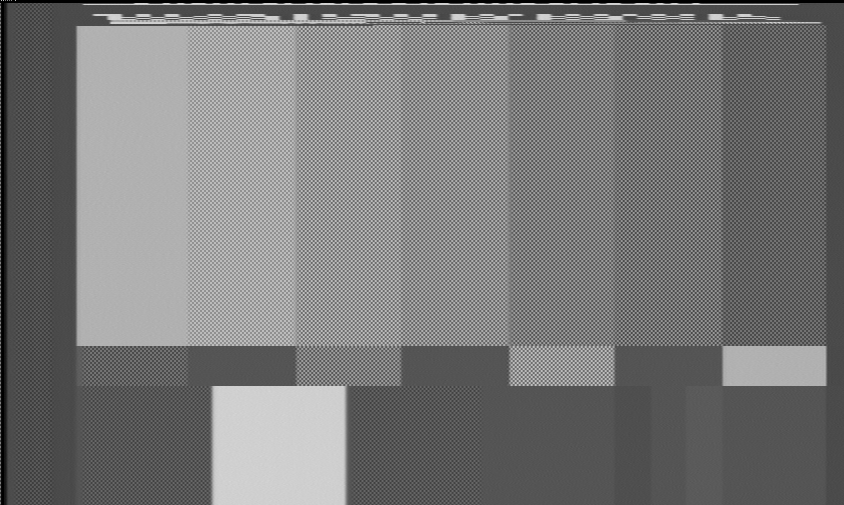

In [8]:
drawdata(data1)

In [9]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.2)
#with tf.Session(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options)) as sess:
    #print('hi!')

In [10]:
session = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

In [11]:
data1.shape

(426220,)

In [26]:
ntscimg_shape = [1, 505, 844, 1]

# Create I and Q mask images

IQmask_p = np.zeros((505, 844), dtype=np.float32)

for i in range(0, 844, 4):
    # We can transpose the array and set all values of a column at once
    IQmask_p.T[i + 0] = 1
    IQmask_p.T[i + 1] = -1
    IQmask_p.T[i + 2] = -1
    IQmask_p.T[i + 3] = 1
    
IQmask = tf.Variable(IQmask_p.reshape(ntscimg_shape), dtype=tf.float32)
IQmask.initializer.run()

partIQp = np.zeros((844), dtype=np.int32)

for i in range(0, 844, 2):
    # We can transpose the array and set all values of a column at once
    partIQp[i] = 0
    partIQp[i + 1] = 1
    
partIQ = tf.Variable(partIQp.reshape([1, 844]), dtype=tf.int32)
partIQ.initializer.run()

stitchIQ1p = np.where(partIQp == 0)[0]
stitchIQ2p = np.where(partIQp == 1)[0]

stitchIQ1 = tf.Variable(stitchIQ1p.reshape([1, 422]), dtype=tf.int32)
stitchIQ1.initializer.run()
stitchIQ2 = tf.Variable(stitchIQ2p.reshape([1, 422]), dtype=tf.int32)
stitchIQ2.initializer.run()




In [39]:
ntscimg_shape = [1, 505, 844, 1]

x = tf.placeholder(tf.float32, ntscimg_shape)
partition = tf.placeholder(tf.int32, [1, 505])
stitches1 = tf.placeholder(tf.int32)
stitches2 = tf.placeholder(tf.int32)

phaseinvert = tf.Variable(np.full((505, 844),-1,dtype=np.float32).reshape(ntscimg_shape), dtype=tf.float32)
phaseinvert.initializer.run()

# create color data
YC_convolve = tf.Variable(np.array([0.5, -1, 0.5]).reshape(1, 3, 1, 1), dtype=tf.float32)
YC_convolve.initializer.run()

c = tf.nn.conv2d(x, YC_convolve, strides=[1, 1, 1, 1], padding="SAME")

# fix phase and levels
csplit = tf.dynamic_partition(c, partition, 2)
csplit[1] *= -1 
c_fixedphase = tf.reshape(tf.dynamic_stitch([stitches1, stitches2], csplit), ntscimg_shape)
c_fixedlevels = c_fixedphase * IQmask

# break out I and Q

c_fixedlevelsT = tf.transpose(c_fixedlevels)

partedIQ = tf.dynamic_partition(c_fixedlevelsT, partIQ, 2)
I = tf.reshape(tf.transpose(partedIQ[0]), [1, 505, 422, 1])
Q = tf.reshape(tf.transpose(partedIQ[1]), [1, 505, 422, 1])

# Processing goes here

# Combine I and Q back together
It = tf.transpose(I)
Qt = tf.transpose(Q)
IQs = tf.dynamic_stitch([stitchIQ1, stitchIQ2], [It, Qt])

C_afterproc = tf.reshape(tf.transpose(IQs), ntscimg_shape) * IQmask
#C_iqm2 = C_afterproc * IQmask

# re-invert phase and levels for YC sep

csplit2 = tf.dynamic_partition(C_afterproc, partition, 2)
#csplit2[0] *= -1 
csplit2[1] *= -1 
c_fory0 = tf.dynamic_stitch([stitches1, stitches2], csplit2)
c_fory = tf.reshape(c_fory0, ntscimg_shape)

y = x + c_fory

in_partition = np.int32(data1.reshape(505,844)[:,0] == 32768).reshape(1,505)
in_stitches1 = np.where(in_partition == 0)[1]
in_stitches2 = np.where(in_partition == 1)[1]

output = session.run([y, I, Q, c_fixedphase, C_afterproc], feed_dict={x: data1.T.reshape(1,505,844,1), 
                                                      partition: in_partition,
                                                      stitches1: in_stitches1,
                                                      stitches2: in_stitches2})



(426220,)
uint8 (505, 844) (505, 844)


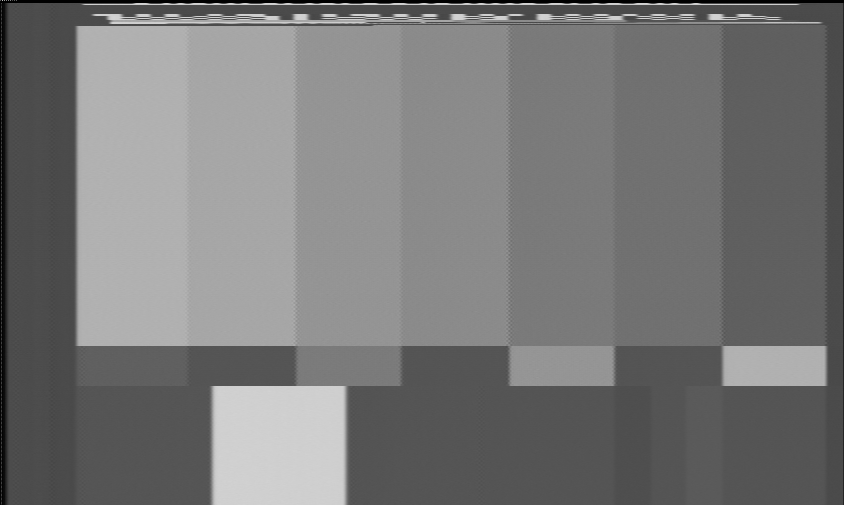

In [40]:
o = 0
I_out = output[o].reshape(output[o].shape[1] * output[o].shape[2])


drawdata(I_out, 844, 505)
#drawdata(data_out, 844, output[-1].shape[1])

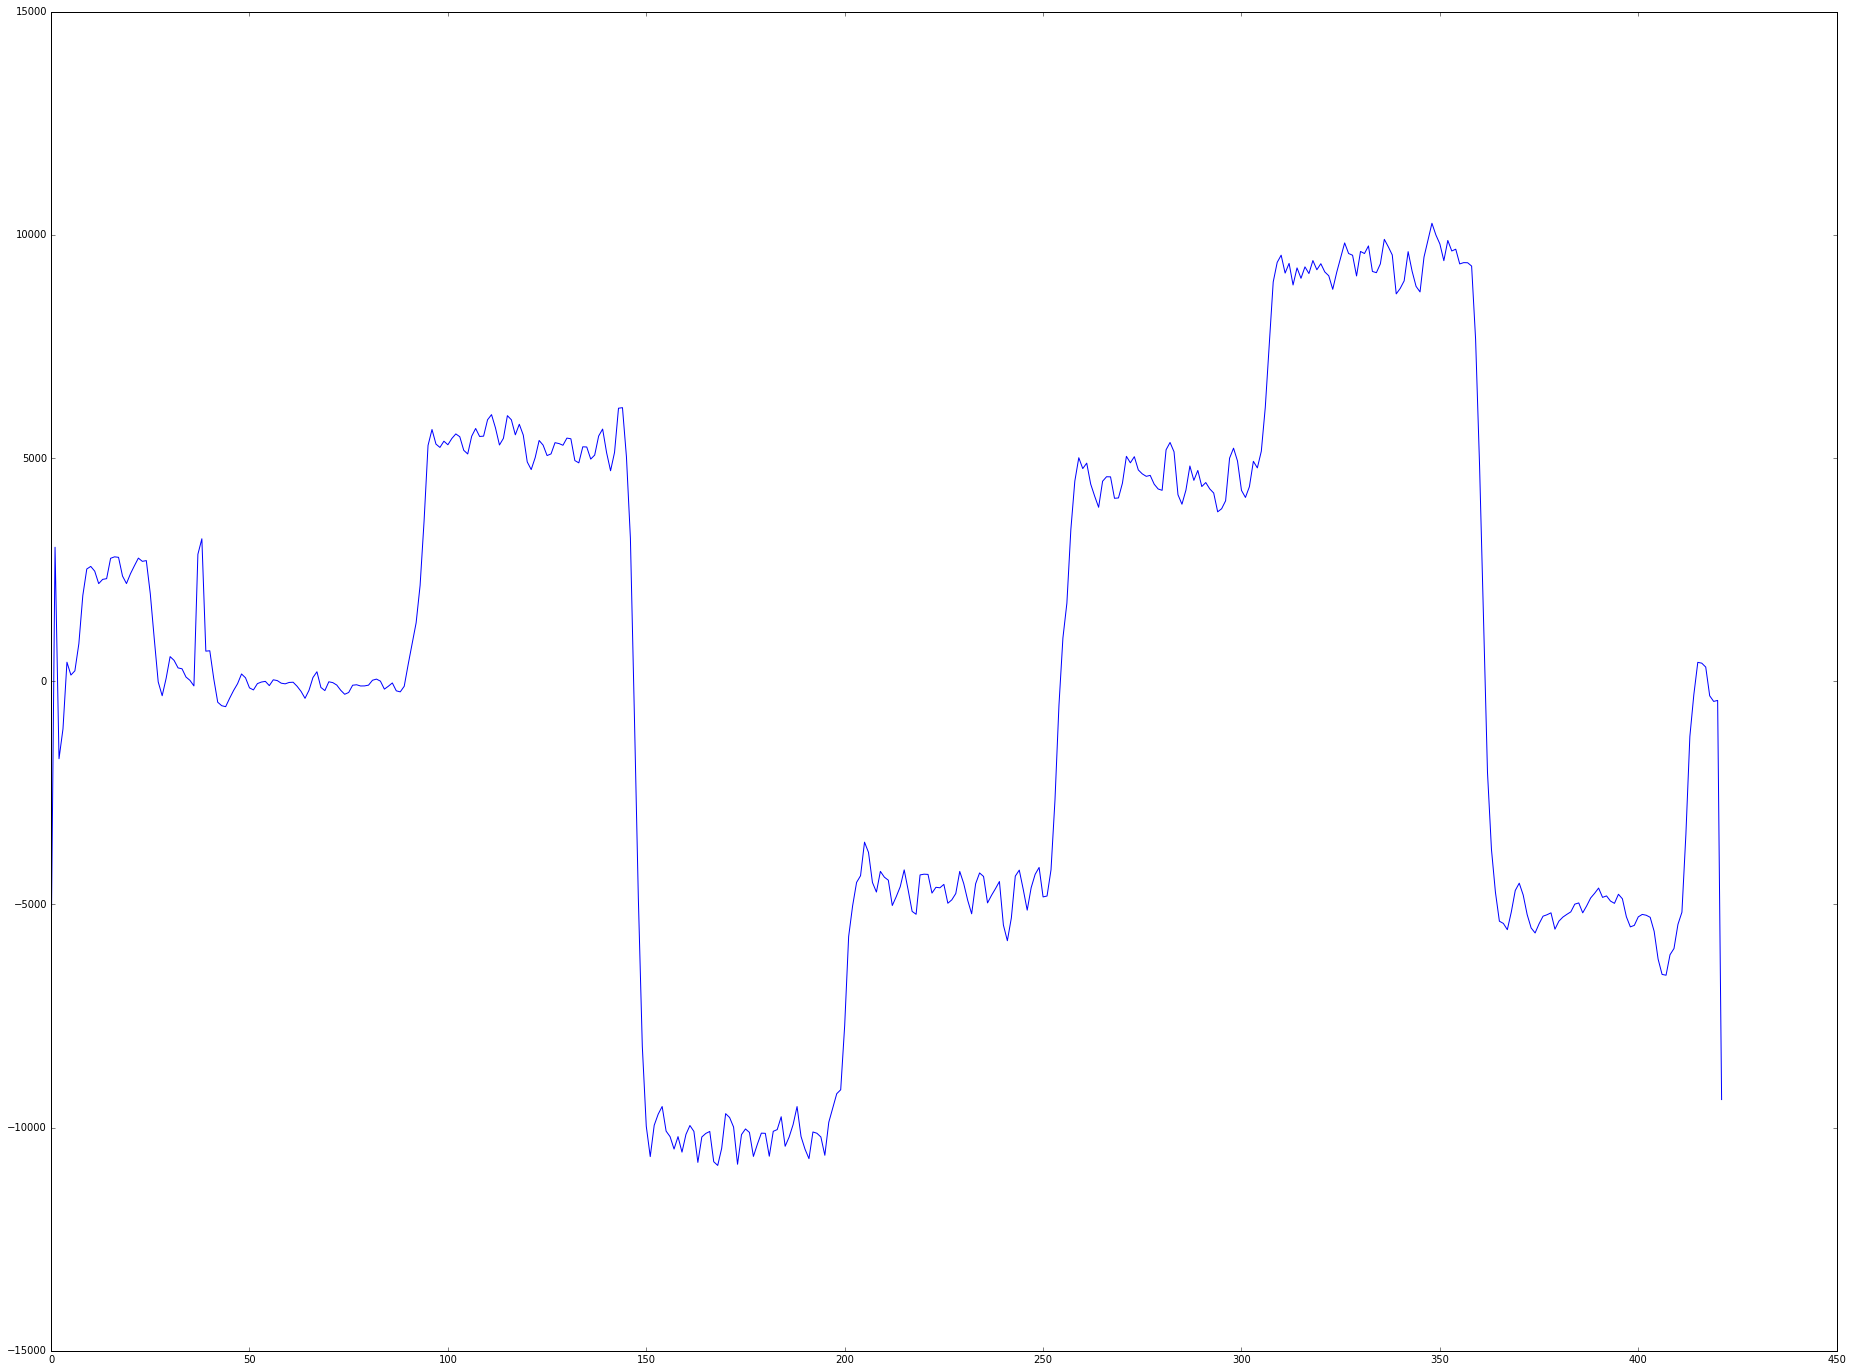

In [34]:
plt.plot(output[2].reshape((505,422))[100])

(426220,)
uint8 (505, 844) (505, 844)


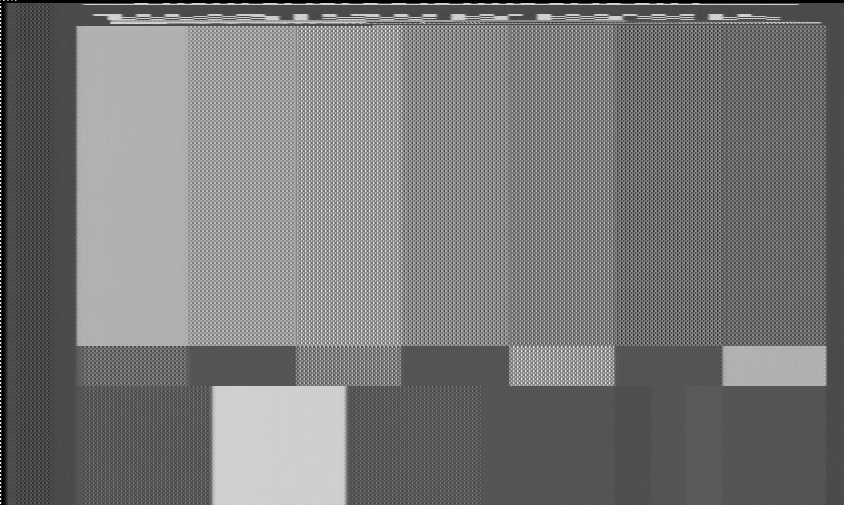

In [53]:
data_out = output[0].reshape(505 * 844)
data_out2 = output[1].reshape(505 * 844)
drawdata(np.abs(data_out), 844, 505)

In [56]:
tmp = output[2]
tmp = tmp.reshape((505, 844))

len(tmp[100]), np.int32(tmp[100])

(844, array([-15382,   6189,      0,      0,  -2818,   1736,      0,      0,
         -1620,   -425,      0,      0,   -305,   -232,      0,      0,
         -1912,  -1920,      0,      0,  -3675,  -2571,      0,      0,
         -3955,  -2186,      0,      0,  -3094,  -2297,      0,      0,
         -3056,  -2786,      0,      0,  -3827,  -2356,      0,      0,
         -3596,  -2406,      0,      0,  -3326,  -2757,      0,      0,
         -3172,  -2701,      0,      0,  -1822,   -954,      0,      0,
          -603,    325,      0,      0,    163,   -550,      0,      0,
           -13,   -298,      0,      0,    -19,    -93,      0,      0,
            65,    106,      0,      0,    501,  -3190,      0,      0,
          -143,   -681,      0,      0,   -522,    471,      0,      0,
           400,    570,      0,      0,    714,    207,      0,      0,
          -145,   -162,      0,      0,    -57,    149,      0,      0,
           133,     54,      0,      0,    117,      3,    

(426220,)
uint8 (505, 844) (505, 844)


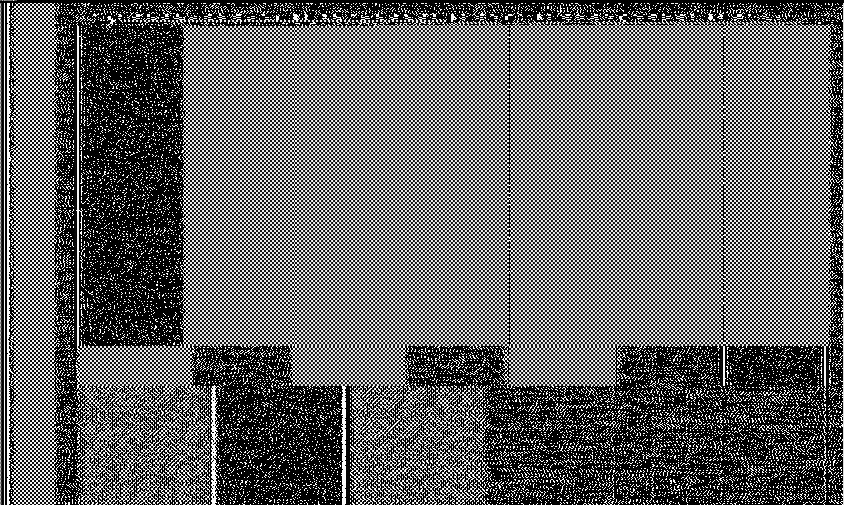

In [650]:
o = 1
data_out = output[o].reshape(output[o].shape[1] * output[o].shape[2])
drawdata(data_out, output[o].shape[2], output[o].shape[1])

In [567]:
output[0].shape

(1, 505, 844, 1)

In [568]:
output[0].shape

(1, 505, 844, 1)

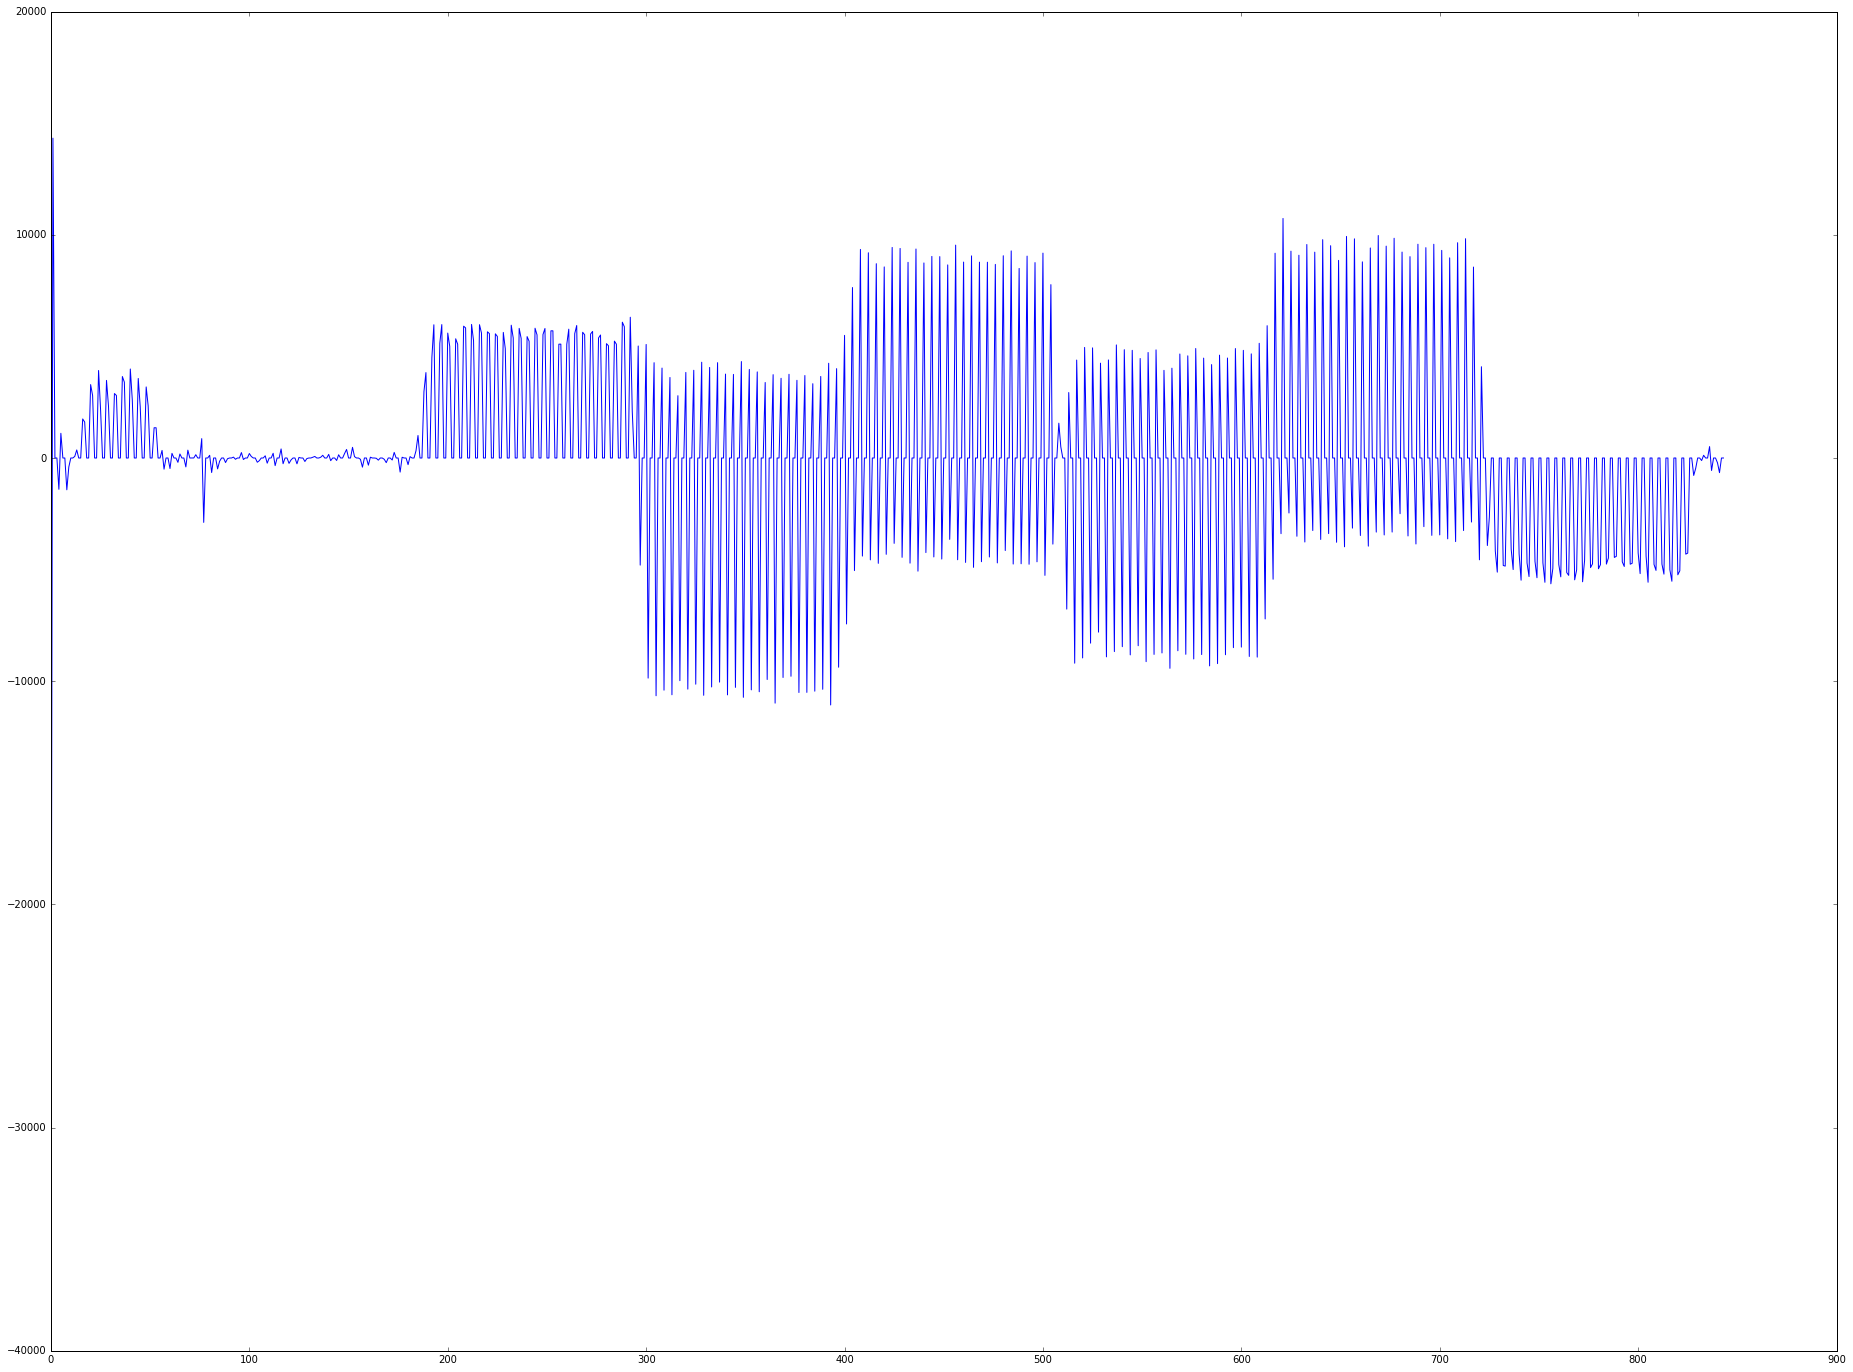

In [681]:
tmp = output[-1].reshape((505, 844))
plt.plot(tmp[202])

In [528]:
output[-1][0].shape[0] / 505

1.0

In [324]:
datac1 = output[1][0].reshape(output[1][0].shape[0] * output[1][0].shape[1])
datac2 = output[1][1].reshape(output[1][1].shape[0] * output[1][1].shape[1])
#drawdata(datao4, 844, 254)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [325]:
tmp1 = datac1.reshape(254, 844)
tmp2 = datac2.reshape(output[1][1].shape[0], 844)
for i in range(360, 440):
    print(i, i % 4, tmp1[100][i], tmp2[100][i])
#plt.plot(tmp[100])

ValueError: total size of new array must be unchanged

In [208]:
output[5].shape

(1, 251, 844, 1)

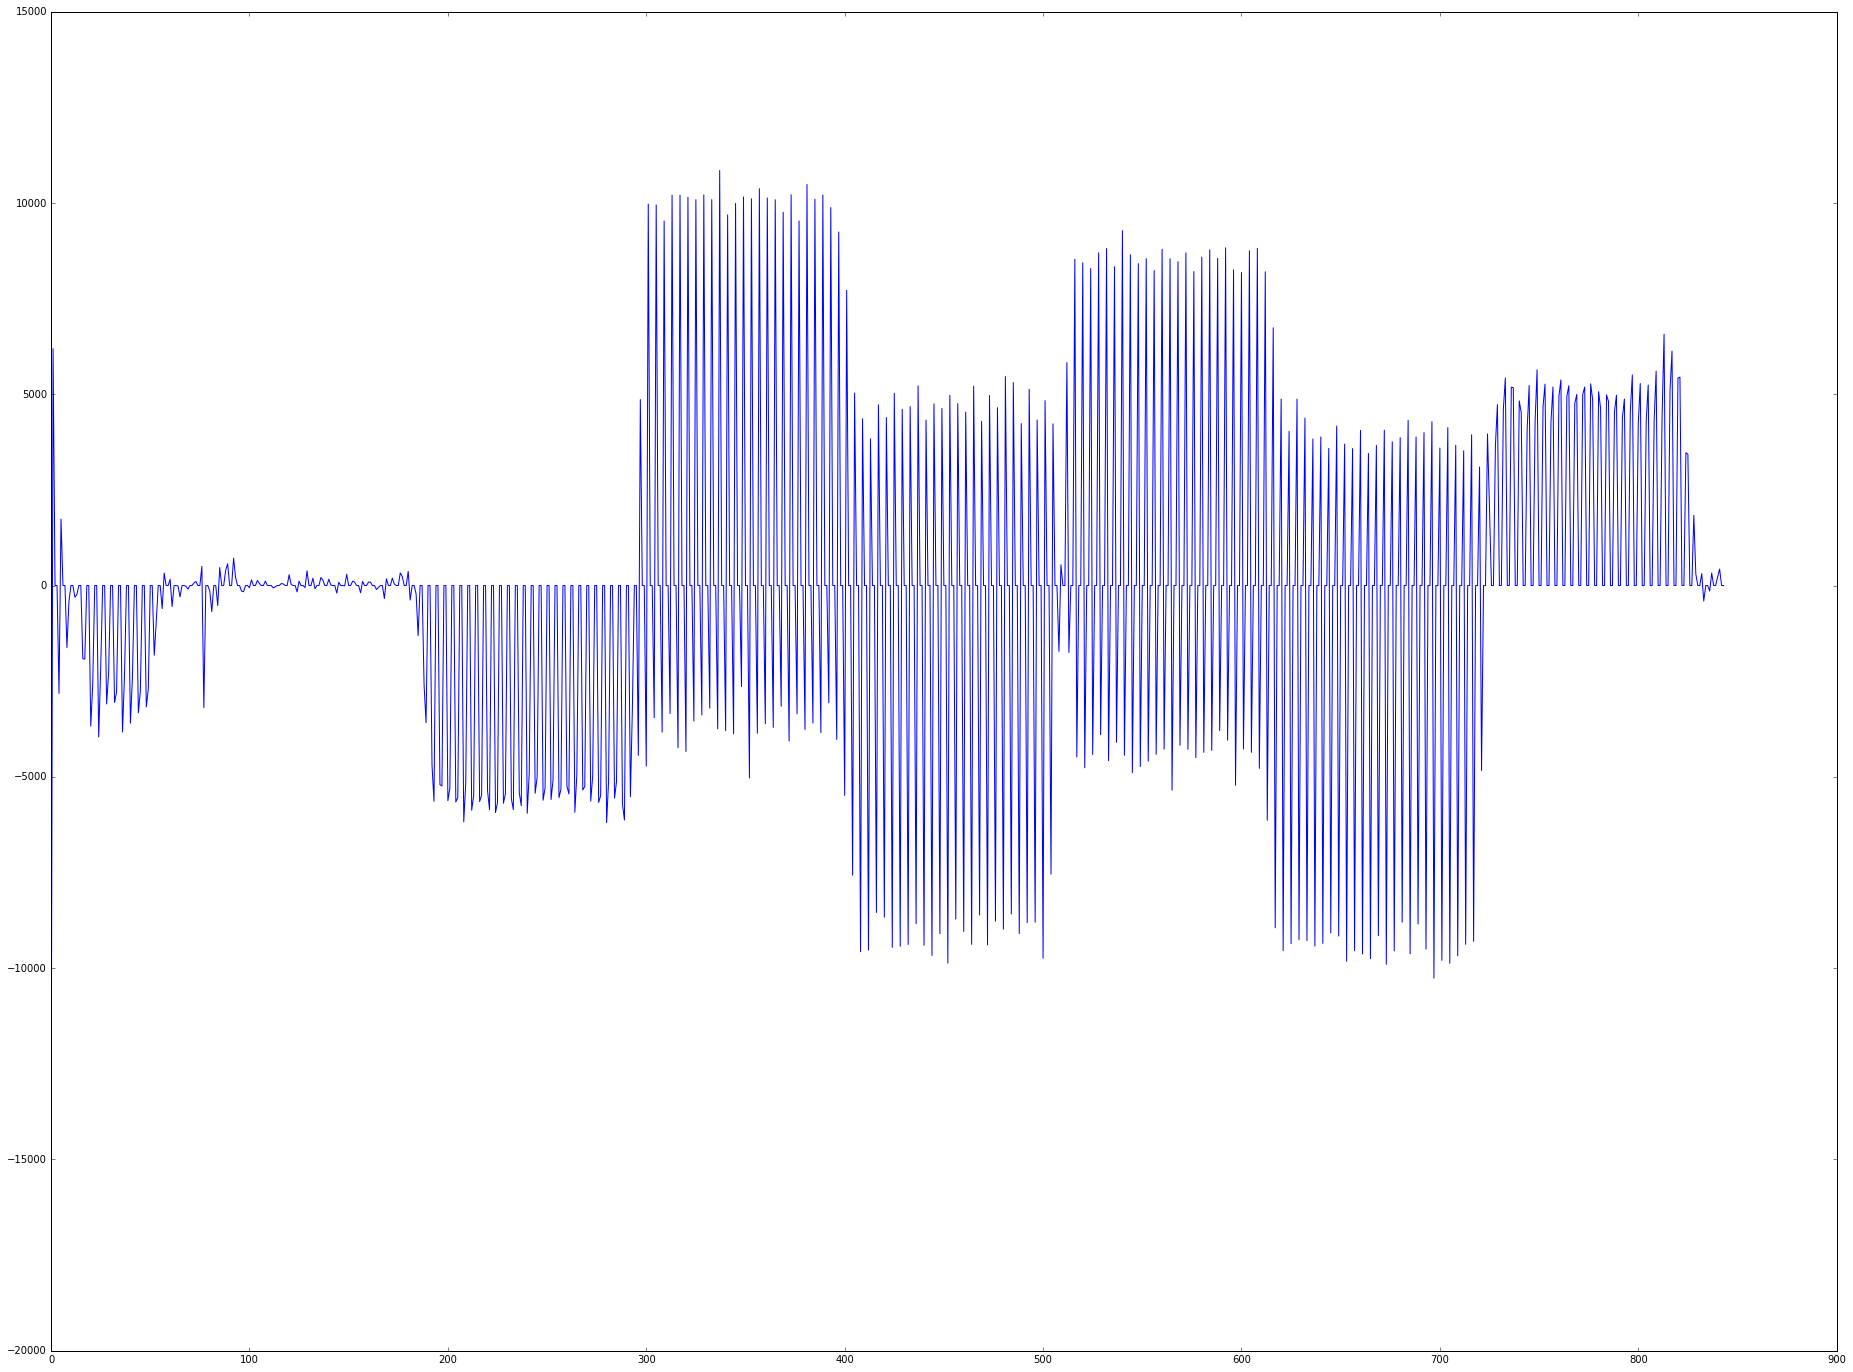

In [438]:
#plt.plot(output[3][0][100])
plt.plot(output[-1][0][100])

(426220,)
uint8 (505, 844) (505, 844)


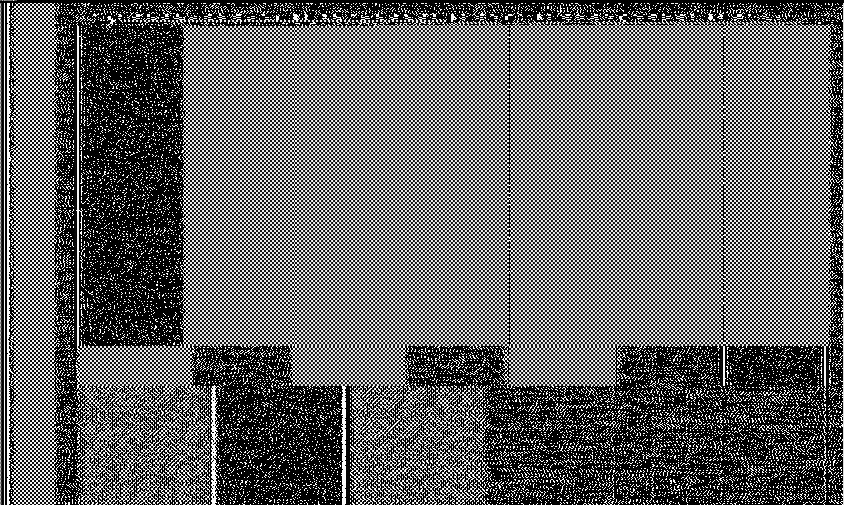

In [229]:
data2 = output[1].reshape(426220)
drawdata(data2)

In [41]:
data2a = data1 - data2

(426220,)
uint8 (505, 844) (505, 844)


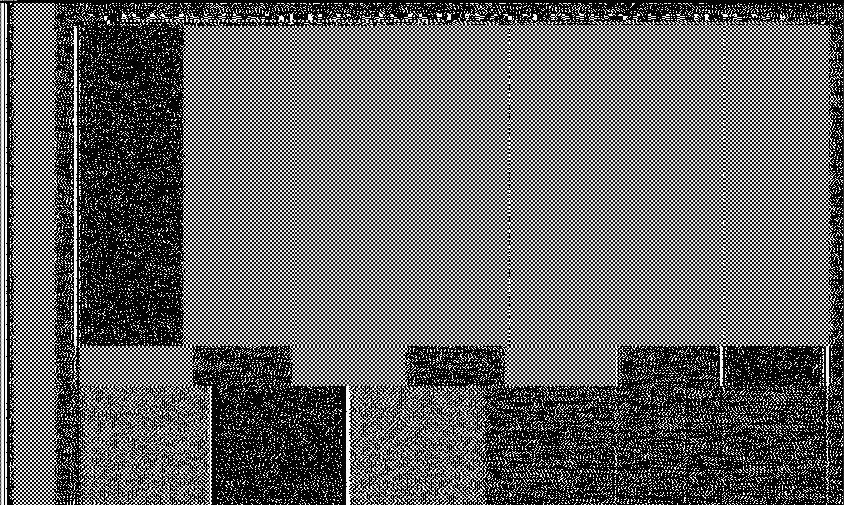

In [42]:
drawdata(data2a)

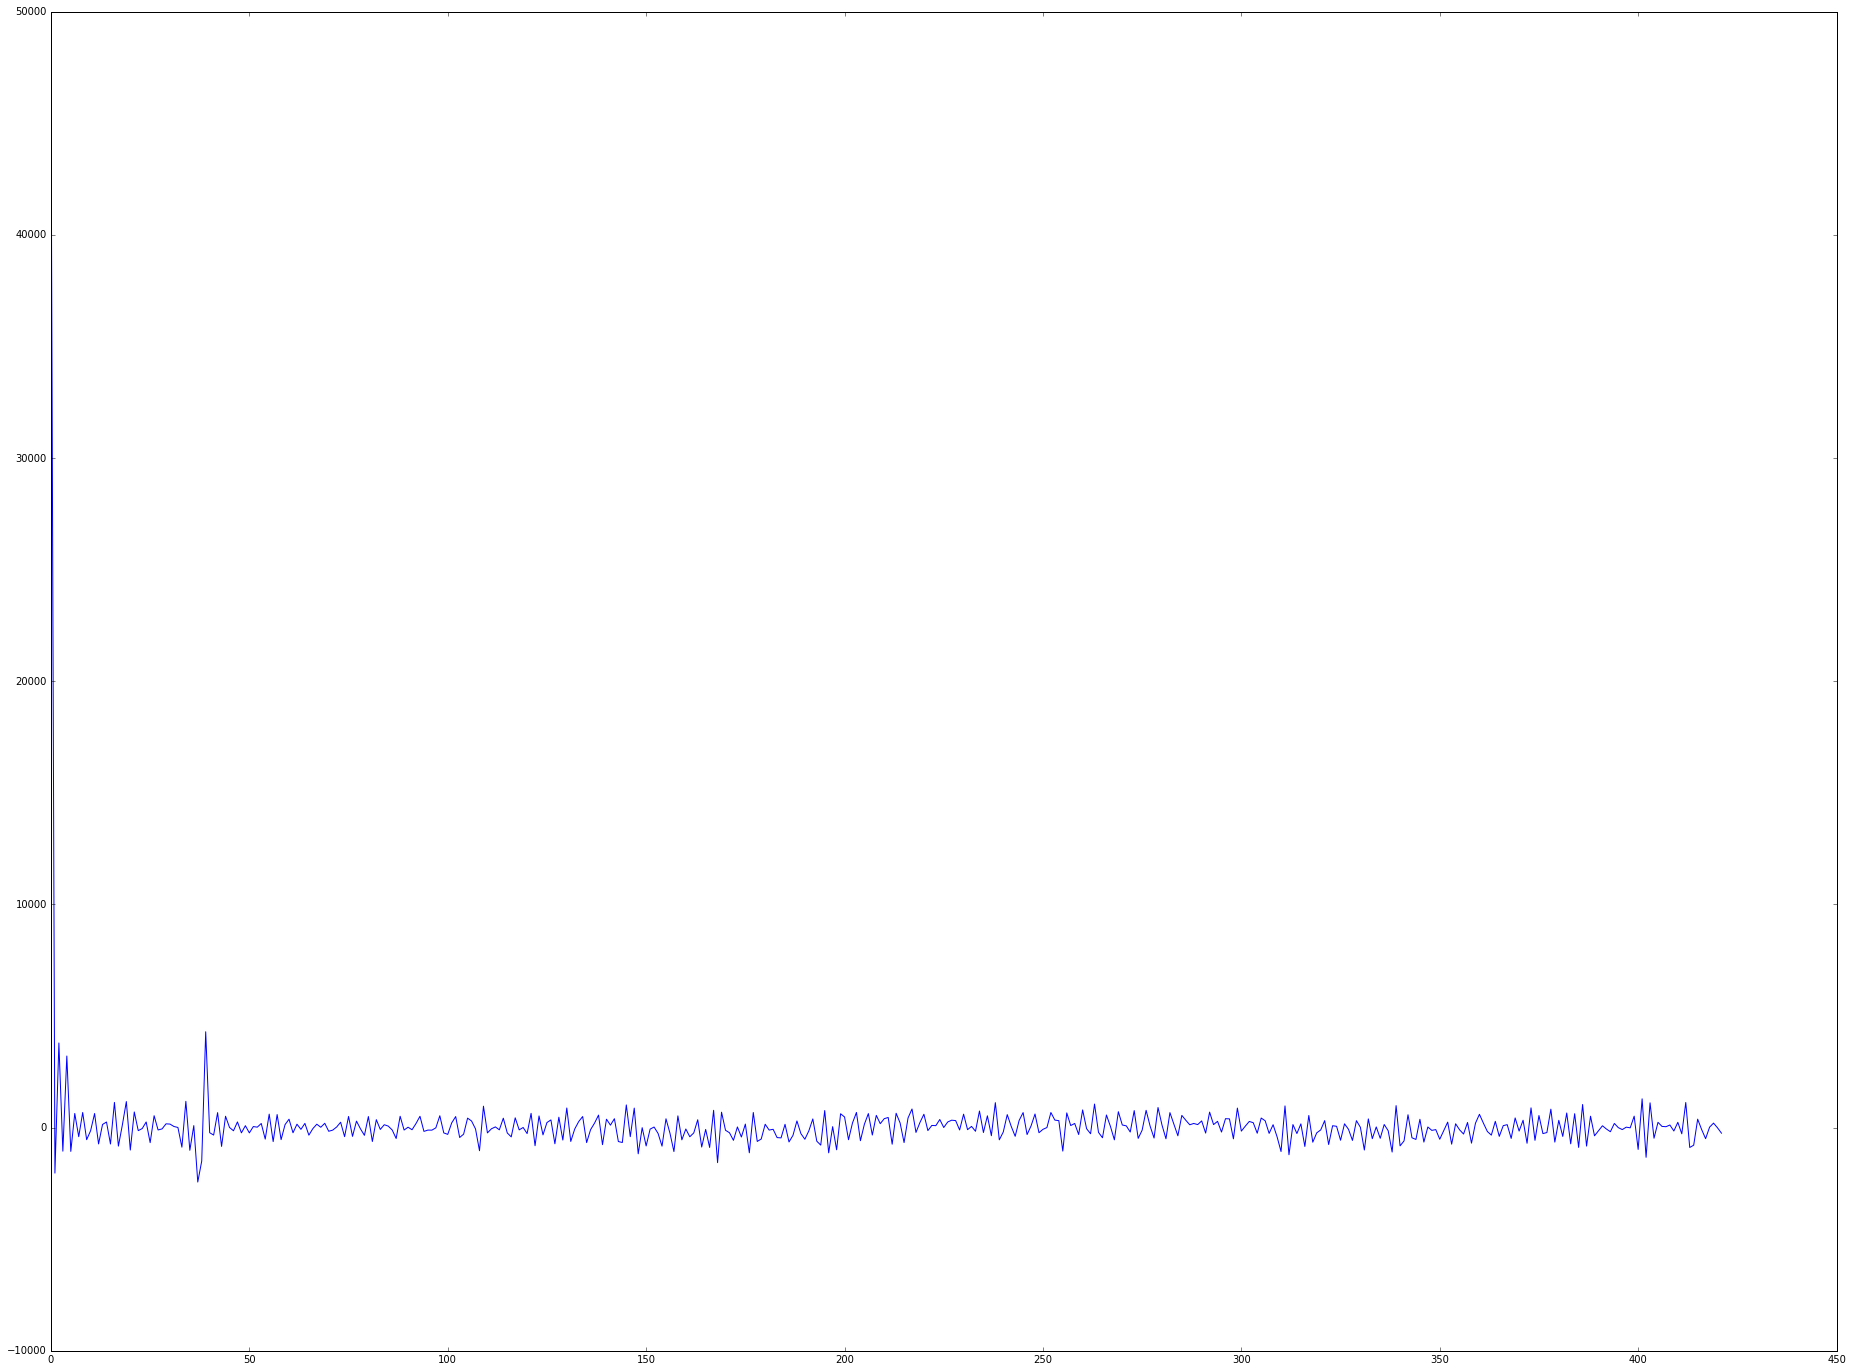

In [99]:
#plt.plot(data2a[844*200:844*201:2] + data2a[844*202:844*203:2])
plt.plot(data2a[0+(844*200):0+(844*201):2] + data2a[0+(844*202):0+(844*203):2])

In [11]:
# example from NIH/mups
def conv1d(dshape, filtlen):
    batch_size = dshape[0]

    x = tf.placeholder(tf.float32, [dshape[1], 1, dshape[0], 1])

    filt = tf.placeholder(tf.float32, [1, filtlen, 1, 1])
    
#    filt = tf.Variable(np.array([-2, -1, 7, -1, -2]).reshape(1, 5, 1, 1), dtype=tf.float32)
#    filt.initializer.run()

    output = tf.nn.conv2d(x, filt, strides=[1, 1, 1, 1], padding="SAME")

    #x = session.run([output], feed_dict={x: data.T.reshape(16,1,240000,1)})
    
    return lambda data, infilt : session.run([output], 
                                             feed_dict={x: data.T.reshape(16,1,240000,1),
                                                        filt: infilt.reshape(1,filtlen,1,1)})[0].T.reshape(240000,16)

def conv1da(dshape, filtlen, padding="SAME"):
    batch_size = dshape[0]
    channels = dshape[1]

    x = tf.placeholder(tf.float32, [channels, 1, batch_size, 1])
    filt = tf.placeholder(tf.float32, [1, filtlen, 1, 1])
    
    # use 'SAME' for same return length?
    output = tf.nn.conv2d(x, filt, strides=[1, 1, 1, 1], padding=padding)

    def doconv1d(data, infilt):
        feed_dict = {x: data.T.reshape(channels,1,batch_size,1),
                     filt: infilt.reshape(1,filtlen,1,1)}
        
        out = session.run([output], feed_dict)[0].T
        #print(out.T.shape)
        return out.reshape(out.shape[1],out.shape[3])

    return doconv1d
    

In [45]:
data1[240][0:100]

array([16384,  2013,     0,     0,  6026,  7066, 10284, 15688, 19126,
       19413, 19142, 19251, 19665, 18819, 18048, 19608, 22044, 20344,
       16028, 16888, 22846, 22434, 16031, 16551, 23272, 22010, 15237,
       16727, 23397, 21871, 15293, 17112, 22939, 21615, 16579, 17508,
       22620, 22066, 16133, 17065, 23318, 22522, 16453, 16855, 22504,
       21775, 16267, 17232, 22507, 21996, 17229, 16677, 19665, 19920,
       18403, 18863, 19496, 18577, 18921, 19718, 18903, 18715, 19360,
       18922, 19103, 19337, 19329, 19010, 18755, 19104, 19313, 18764,
       19037, 18878, 19366, 23058, 30924, 40194, 44724, 44354, 44526,
       45392, 45413, 45194, 45529, 45643, 45478, 45430, 45234, 45377,
       45524, 45656, 45322, 45113, 45406, 45520, 45451, 45583, 45740, 45332], dtype=uint16)

In [48]:
import scipy.signal as sps

In [59]:
# dusted off FIR filters from earlier ld decode version - IIR 
# requires FFT, which *for now* needs a graphics card in TensorFlow

freq4 = (315 / 88.0) * 4

Ncolorlp = 16
colorlpi_filter = sps.firwin(Ncolorlp + 1, [1.6 / (freq4 / 2)], window='hamming')
colorlpq_filter = sps.firwin(Ncolorlp + 1, [0.55 / (freq4 / 2)], window='hamming')


In [57]:
# determine which convolutions and masks to use
def getphase(picture):
    c = 0
    for i in range(10, 500, 2):
        c += picture[i][0] > 0
        
    return c > 230
        
getphase(data1)

True

In [58]:
# convolution used for color phase splitting (adapted from comb-ntsc tc1)

conv_yc = [.5, 0, -1, 0, .5]
conv_yc_inv = [-.5, 0, 1, 0, -.5] # invert on phase shift

In [ ]:
# build "checkerboards" for each type of frame

In [63]:
# Test code that may or may not get used
def conv1d(dshape, filtlen, padding="SAME"):
    batch_size = dshape[0]
    channels = dshape[1]

    x = tf.placeholder(tf.float32, [channels, 1, batch_size, 1])
    filt = tf.placeholder(tf.float32, [1, filtlen, 1, 1])
    
    # use 'SAME' for same return length?
    output = tf.nn.conv2d(x, filt, strides=[1, 1, 1, 1], padding=padding)

    def doconv1d(data, infilt):
        feed_dict = {x: data.T.reshape(channels,1,batch_size,1),
                     filt: infilt.reshape(1,filtlen,1,1)}
        
        out = session.run([output], feed_dict)[0].T
        #print(out.T.shape)
        return out.reshape(out.shape[1],out.shape[3])

    return doconv1d    

<h3>Layer structure</h3>

- There are two possible line phases, which need different convolutions to get
  the correct color values.  Each frame inverts phases... but pause mode and 
  scanning/skipping can disrupt that.  So we should probably check an area of each 
  frame to be safe.
  
  (could also look at each color burst, but that kinda sequential code is horrible in
  Python and I doubt it can be worked into the graph.)



- 4FSC provides mathematical advantages.  Each pixel is a unique I/Q phase...

p0 +I, p1 -Q, p2 -I, p3 +Q

- In comb-ntsc.cxx 1 and 2 are inverted to enable color level filtering and inverted for IQ values.  For this version should we split it into 2 422-row pictures and apply filters that way, then stitch back into 844?



Possible chain:

- YC convolution (switchable masks for each field type)


- splitting on IQ (dynamic partition)
- I Q filtering
- (2D corrections?)


- desplitting (tf.dynamic_stitch)
- remove C from Y 


In [60]:
# 505 batches of 1hx844w convolutions

frame = tf.placeholder(tf.float32, [505, 1, 844, 1])

In [390]:
tmp = np.zeros((505, 844))
for x in range(0, 844):
    for y in range(0, 505):
        tmp[y][x] = x 

In [398]:
tmp.T[::2].T

array([[   0.,    2.,    4., ...,  838.,  840.,  842.],
       [   0.,    2.,    4., ...,  838.,  840.,  842.],
       [   0.,    2.,    4., ...,  838.,  840.,  842.],
       ..., 
       [   0.,    2.,    4., ...,  838.,  840.,  842.],
       [   0.,    2.,    4., ...,  838.,  840.,  842.],
       [   0.,    2.,    4., ...,  838.,  840.,  842.]])

In [413]:
tmp[::,::2].shape

(505, 422)